## 1. Tool calling
We will see a usecase how to call tool.

We will also see a simple agentic AI usecase where llm does some reasoning after getting the response from tool.

`llm.bindtoorls` is the main function for adding tool capacity to the llm


In [17]:
import os
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_ibm import ChatWatsonx

In [18]:
from dotenv import load_dotenv
load_dotenv()

True

In [19]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [20]:
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]

In [21]:
WATSONX_APIKEY = os.getenv('WATSONX_APIKEY', None)
WATSONX_PROJECT_ID = os.getenv('WATSONX_PROJECT_ID', None)
URL = os.getenv("WATSONX_URL","https://us-south.ml.cloud.ibm.com")

llm = ChatWatsonx(
    model_id="meta-llama/llama-3-3-70b-instruct",
    url = URL,
    apikey = WATSONX_APIKEY,
    project_id = WATSONX_PROJECT_ID,
)

llm_with_tools = llm.bind_tools(tools)

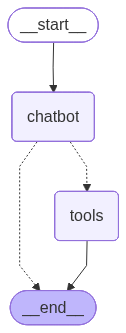

In [22]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

**This agent either gets the stock price from stock tool. If the query is not related to stock then go with the default path.** 

In [23]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [24]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [16]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

150.0


**Response to above is the not currect because it does not doing anything after fetching the stock price**

## 2. Adding the extra node for checking question is answered are not.

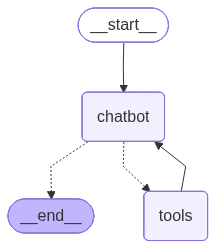

In [25]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

The current price of AAPL stock is $100.4.


In [28]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein.


In [30]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

The total cost of buying 20 AMZN stocks and 15 MSFT stocks can be calculated by multiplying the number of stocks by their respective prices and adding them together. 

For 20 AMZN stocks at $150.0 each, the cost is 20 * $150.0 = $3000.0. 
For 15 MSFT stocks at $200.3 each, the cost is 15 * $200.3 = $3004.5. 

The total cost is $3000.0 + $3004.5 = $6004.5.


**In the above output you can overserve that Tool has been called 2 times and then after the response from 2 Tools calls.
LLM is doing the calculations to give response that whould answer User's query**

In [32]:
msg = "Tell me the current price of 5 MSFT stocks and add it to previous total"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

The current price of 5 MSFT stocks is 5 * 200.3 = 1001.5. To add this to a previous total, you would need to know the previous total. If the previous total was 500, the new total would be 1001.5 + 500 = 1501.5.


### Above response we can observe that agent does not know the previous total which was repsonse of our previous call.
To make it work we need to `memory` to the agent now.